In [24]:
import geojson
import geopy
import numpy as np
from geopy.distance import vincenty
import matplotlib.pyplot as plt
import progressbar
import pandas as pd
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian2DKernel

In [29]:
# Loading crime csv to RDD
# Replace with your directory
crime_csv = sc.textFile('file:/Users/zhuorulin/Documents/DataScience/datasets/NYPD_Complaint_Data_Historic.csv',use_unicode=False)

# Convert csv to DataFrame
from csv import reader # Warning: csv.reader does not support unicode decode
from pyspark.sql import SQLContext
from collections import defaultdict
import datetime
import re
import pandas as pd

# Use csv.reader to read raw binary
lines_rdd = crime_csv.mapPartitions(reader)\
.map(lambda line: [x.decode('utf-8').strip() for x in line] )# Decode with utf-8 codec
# store columns values. Also a search table for searching column name using index
schemas = lines_rdd.take(1)[0]
# filter out first row
lines = lines_rdd.filter(lambda x: x!=schemas)

# This dict makes it easier to search for column index using column name
colname2idx = defaultdict()
for idx,colname in enumerate(schemas):
    colname2idx[colname] = idx

In [30]:
print(schemas)

[u'CMPLNT_NUM', u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT', u'CMPLNT_TO_TM', u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD', u'PD_DESC', u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC', u'BORO_NM', u'ADDR_PCT_CD', u'LOC_OF_OCCUR_DESC', u'PREM_TYP_DESC', u'PARKS_NM', u'HADEVELOPT', u'X_COORD_CD', u'Y_COORD_CD', u'Latitude', u'Longitude', u'Lat_Lon']


In [31]:
#Get MTA Station Data
f= open('./Subway Entrances.geojson','r')
mta_entrances_json = geojson.load(f)
mta_entrances = mta_entrances_json.features
mta_entrances_cdns = [point.geometry.coordinates for point in mta_entrances]
mta_entrances_cdns = np.array(mta_entrances_cdns)

In [32]:
crime_txt = sc.textFile('file:/Users/zhuorulin/Documents/DataScience/big-data-project/crime-data-process/results/data-summarization/heatmap_coordinates/crime_heatmap_2015_no_reduce.out')
lines = crime_txt.map(lambda line: line.split(',')[:2]).map(lambda line:[float(coor_str) for coor_str in line])\
.map(lambda line: [line[1],line[0]])
lines.take(1)
crime_coordinates = np.array(lines.collect())

In [21]:
crime_coords_manh = lines.filter(lambda x: x[colname2idx['BORO_NM']]=='MANHATTAN')\
.map(lambda x: [x[colname2idx['Longitude']],x[colname2idx['Longitude']]])\
.filter(lambda x: x[0]!='')\
.collect()

In [22]:
crime_coords_manh_np = np.array(lines,dtype=float)

TypeError: float() argument must be a string or a number

In [33]:
#Function for calculating MTA Potential
def cal_potential(x,stations_coordinates = mta_entrances_cdns):
    potential_list = [1/(vincenty(x,station).km)**2 for station in stations_coordinates]
    return sum(potential_list)

In [34]:
#Get grid count, 100*100 grid correspond to a 460m*460m area
latitude = crime_coordinates[:,1]
longitude = crime_coordinates[:,0]
heatmap, xedges, yedges = np.histogram2d(-latitude,longitude, bins=100)

In [35]:
#Calculate grid edge length
vincenty(xedges[1],xedges[2]).m

459.55362130831674

In [36]:
energy = []
count_list = []
idx=0
bar = progressbar.ProgressBar(max_value=10000)
energy_map= np.zeros([100,100])
for i in range(100):
    for j in range(100):
        idx+=1
        bar.update(idx)
        count = heatmap[i,j]
        if count==0:
            continue
        latitude = -(xedges[i]+xedges[i+1])/2
        longitude = (yedges[j]+yedges[j+1])/2
        energy.append(cal_potential([longitude,latitude]))
        count_list.append(count)
        energy_map[i,j] = energy[-1]

100% (10000 of 10000) |####################| Elapsed Time: 0:05:00 ETA:  0:00:00

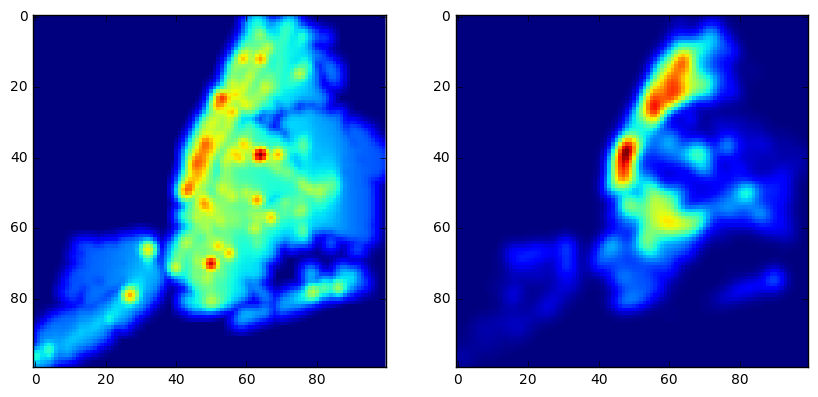

In [38]:
#Visualization of energy
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
convolve_heat = convolve(energy_map, Gaussian2DKernel(stddev=2))
plt.imshow(convolve(energy_map, Gaussian2DKernel(stddev=1))**0.2, interpolation='none')
plt.savefig('mta_energy2.png')
plt.subplot(1,2,2)
plt.imshow(convolve(heatmap, Gaussian2DKernel(stddev=2))**0.9, interpolation='none')
plt.show()

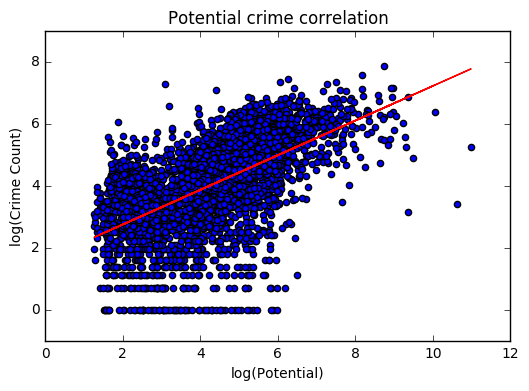

In [51]:
fit = np.polyfit(np.log(energy),np.log(count_list),deg=1)
plt.figure(figsize=(15,5))
df_2plot = pd.DataFrame()
df_2plot['energy'] = np.log(energy)
df_2plot['gridcount'] = np.log(count_list)
df_2plot.plot.scatter('energy','gridcount')
plt.plot(np.log(energy),fit[0]*np.log(energy)+fit[1],color='r')
plt.xlabel('log(Potential)')
plt.ylabel('log(Crime Count)')
plt.title('Potential crime correlation')

plt.savefig('potential_corr.png')
plt.show()

In [25]:
np.corrcoef(np.log(energy),np.log(count_list))

array([[ 1.        ,  0.55795011],
       [ 0.55795011,  1.        ]])

# Distribution of three different level of crime

In [ ]:
VI